In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
model = VGG16(weights='imagenet', include_top = False, input_shape = (32,32,3))

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [4]:
for layer in model.layers:
    layer.trainable = False

In [5]:
model1 = Sequential()
for layer in model.layers:
    model1.add(layer)
    

In [6]:
model1.add(Flatten())
model1.add(Dense(10, activation = 'softmax', name = 'preds'))

In [7]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

In [8]:
for layer in model1.layers:
    layer.trainable = False

In [9]:
for layer in model1.layers[-3:]:
    layer.trainable = True

In [10]:
for layer in model1.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True


In [11]:
classes = os.listdir(r'C:\Users\offic\Documents\GitStuff\NOTEMNIST\notMNIST_small\notMNIST_small')
print(classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


In [12]:
keras.backend.clear_session()

In [13]:
image_gen = ImageDataGenerator(validation_split = 0.3, rescale=1.0/255.0, zoom_range = [0.5,2])
train_gen = image_gen.flow_from_directory(r'C:\Users\offic\Documents\GitStuff\NOTEMNIST\notMNIST_small\notMNIST_small',
                                          target_size = (32,32),
                                          classes = classes,
                                          subset = 'training',
                                          batch_size = 16,
                                          shuffle = True
                                         )
test_gen = image_gen.flow_from_directory(r'C:\Users\offic\Documents\GitStuff\NOTEMNIST\notMNIST_small\notMNIST_small',
                                         target_size = (32,32),
                                         classes = classes,
                                         subset = 'validation',
                                         batch_size = 16,
                                         shuffle = True
                                         )

Found 13114 images belonging to 10 classes.
Found 5610 images belonging to 10 classes.


In [14]:
train_steps = (train_gen.samples//16)
test_steps = (test_gen.samples // 16)

In [15]:
model1.compile(optimizer = 'adam',loss = 'CategoricalCrossentropy',  metrics = ['accuracy'])

Epoch 1/1000
819/819 [==============================] - 14s 17ms/step - loss: 0.6364 - accuracy: 0.8120 - val_loss: 0.6394 - val_accuracy: 0.8138 - lr: 1.0000e-04
Epoch 2/1000
819/819 [==============================] - 14s 17ms/step - loss: 0.6339 - accuracy: 0.8118 - val_loss: 0.6387 - val_accuracy: 0.8188 - lr: 1.0000e-04
Epoch 3/1000
819/819 [==============================] - 14s 17ms/step - loss: 0.6229 - accuracy: 0.8122 - val_loss: 0.6701 - val_accuracy: 0.8070 - lr: 1.0000e-04
Epoch 4/1000
819/819 [==============================] - 14s 17ms/step - loss: 0.6275 - accuracy: 0.8149 - val_loss: 0.6752 - val_accuracy: 0.8145 - lr: 1.0000e-04
Epoch 5/1000
819/819 [==============================] - 14s 17ms/step - loss: 0.6250 - accuracy: 0.8166 - val_loss: 0.6582 - val_accuracy: 0.8111 - lr: 1.0000e-04
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


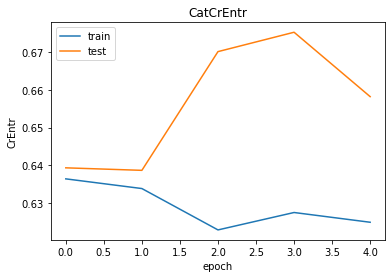

In [17]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      mode = 'auto', 
                                      patience=3,
                                      restore_best_weights=True, 
                                     )
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              patience=3, min_lr=0.00001)

log_dir = r"C:\Users\offic\Documents\GitStuff\NOTEMNIST\logs\fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_filepath = r'C:\Users\offic\Documents\GitStuff\NOTEMNIST\VGG16small check points'
ckpts = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'auto',
    save_best_only = True)



history = model1.fit(train_gen,
                    steps_per_epoch = train_steps,
                    epochs=1000, 
                    callbacks=[es, reduce_lr, tensorboard_callback],
                    validation_data = test_gen,
                    validation_steps = test_steps
                   )

print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CatCrEntr')
plt.ylabel('CrEntr')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()